# Исследование бизнес метрик развлекательного приложения

В данном исследовании рассмотим бизнес метрики развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.

Предоставлены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

В результате исследования необходимо выявить следующее:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Загрузка данных и подготовка их к анализу

Импортируем все необходимые библиотеки для работы с данными.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

Загрузим датасеты, которые содержат данные о визитах, заказах и расходах пользователей в переменные `visits`, `orders` и `costs` соответственно.

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

Отобразим первые строки загруженных датасетов и опишем их структуру.

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


**Описание датасета:**\
`User Id` — уникальный идентификатор пользователя,\
`Region` — страна пользователя,\
`Device` — тип устройства пользователя,\
`Channel` — идентификатор источника перехода,\
`Session Start` — дата и время начала сессии,\
`Session End` — дата и время окончания сессии.

In [4]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


**Описание датасета:**\
`User Id` — уникальный идентификатор пользователя,\
`Event Dt` — дата и время покупки,\
`Revenue` — сумма заказа.

In [5]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Описание датасета:**\
`dt` — дата проведения рекламной кампании,\
`Channel` — идентификатор рекламного источника,\
`costs` — расходы на эту кампанию.

Выведем на экран информацию

In [6]:
for i in [visits, orders, costs]:
    i.info()
    print('Количество строк-дубликатов', i.duplicated().sum())
    display(i.describe().T)
    print('--------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
Количество строк-дубликатов 0


,count,mean,std,min,25%,50%,75%,max
User Id,309901.0,4.997664e+11,2.887899e+11,599326.0,2.493691e+11,4.989906e+11,7.495211e+11,9.999996e+11


--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
Количество строк-дубликатов 0


,count,mean,std,min,25%,50%,75%,max
User Id,40212.0,4.990295e+11,2.860937e+11,599326.00,2.511324e+11,4.982840e+11,7.433327e+11,9.998954e+11
Revenue,40212.0,5.370608e+00,3.454208e+00,4.99,4.990000e+00,4.990000e+00,4.990000e+00,4.999000e+01


--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
Количество строк-дубликатов 0


,count,mean,std,min,25%,50%,75%,max
costs,1800.0,58.609611,107.740223,0.8,6.495,12.285,33.6,630.0


--------------------------------


Полные дубликаты строк и пропуски в данных отсутствуют.

Приведем названия столбцов в датасетах к нижнему регистру и заменим пробелы на символ нижнего подчеркивания.

In [7]:
for i in [visits, orders, costs]:
    i.columns = i.columns.str.lower().str.replace(' ', '_')

В переменных `visits` и `costs` роверим столбцы с категориальными переменными на наличие неявных дубликатов.

In [8]:
print('-visits-')
print()
for i in ['region', 'device', 'channel']:
    print(i)
    print(visits[i].unique())
print('-----------------------------')
print()

print('-costs-')
print()
print('channel')
print(costs['channel'].unique())

-visits-

region
['United States' 'UK' 'France' 'Germany']
device
['iPhone' 'Mac' 'Android' 'PC']
channel
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
-----------------------------

-costs-

channel
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


Неявных дубликатов не выявлено.

Приведем столбцы с указанием даты к формату datetime.

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

В результате предобработки типы данных приведены в соответствие с их содержанием. Дубликатов строк и неявных дубликатов, аномальных значения в данных не выявлено. Пропуски в данных отсутствуют. Названия столбцов приведены к написанию, удобному для дальнейшей работы.

### Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим функции для вычисления метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 5)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 6, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Составим профили пользователей. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

Получим профили пользователей. Для этого вызовем ранее заданную функцию `get_profiles()` и передадим ей данные о посещениях, покупках и тратах на рекламу. 

In [18]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную даты привлечения пользователей.

In [19]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print(f'Минимальная дата привлечения пользователей {min_date}')
print(f'Максимальная дата привлечения пользователей {max_date}')

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


В нашем датафрейме с профилями пользователей хранятся данные за период c 1 мая 2019 г. по 27 октября 2019 г.,что соответствует условаяим проекта.

Зададим функцию, которая будет группировать пользователей по интересующему нас параметру и подсчитывать количество пользователей в группе и процент платящих от общего количества по каждой группе.

In [20]:
# функция для группировки данных по интересующему параметру и подсчета процента платящих пользователей от общего
# по каждой из групп
def payer_by_dim(dim):
    
    # создадим сводную таблицу с группировкой по заданному параметру, и подсчетом общего количества пользователей
    # и подсчетом процента платящих
    by_dim = (
    profiles.pivot_table(index=(dim), values='payer', aggfunc=('count', 'mean'))
    .rename(columns={'count': 'count_users', 'mean': 'perc_of_payer'})
    .sort_values('perc_of_payer', ascending=False)
    )
    
    # домножим значение на 100 и округлим до 2 знака после запятой для отображения показателя в процентах
    by_dim['perc_of_payer'] = round((by_dim['perc_of_payer'] * 100), 2)
    
    return by_dim

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Для этого построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [21]:
payer_by_dim('region')

,count_users,perc_of_payer
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


Больше всего пользователей приходит из США. Наибольшая доля платящих пользователей от общего количества по региону также приходится на США (6,9% платящих пользователей). В Германии, Великобритании и Франции доля платящих пользователей составляет около 4%.

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [22]:
payer_by_dim('device')

,count_users,perc_of_payer
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


Также построим график распределиния платящих пользователей по устройствам.

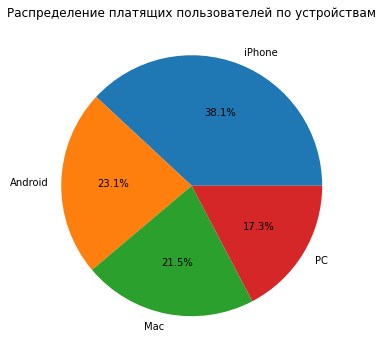

In [23]:
profiles.query('payer == True').pivot_table(index='device', values={'user_id'}, aggfunc='count')\
.rename(columns={'user_id': ' '}).sort_values(' ', ascending=False)\
.plot(kind='pie', subplots=True, figsize=(6, 6), autopct="%1.1f%%", legend=False)
plt.title('Распределение платящих пользователей по устройствам')

plt.show()

Клиенты пользуются устройствами Mac, iPhone, PC, Android. Доля платящих пользователей выше для пользователей Mac (6,36%) и iPhone (6,21%). Среди платящих пользователей наиболее популярен iPhone.

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [24]:
payer_by_dim('channel')

,count_users,perc_of_payer
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


Наибольший процент платящих пользователей привлечен из каналов FaceBoom (12,2%), AdNonSense (11,34%), LambdaMediaAds (10,47%). Менее всего платящих пользователей привлеченно из LeapBob (3,06%) и OppleCreativeMedia (2,71%). В органическом трафике платящих пользователей 2,06%.

### Маркетинг

Вычислим общую сумму расходов на маркетинг. Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник. Визуализируем динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику.
Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

Вычислим общую сумму расходов на маркетинг.

In [25]:
total_cost = costs['costs'].sum()
print(f'Общая сумма расходов на маркетинг ${total_cost:.2f}')

Общая сумма расходов на маркетинг $105497.30


Выясним, как траты распределены по рекламным источникам.

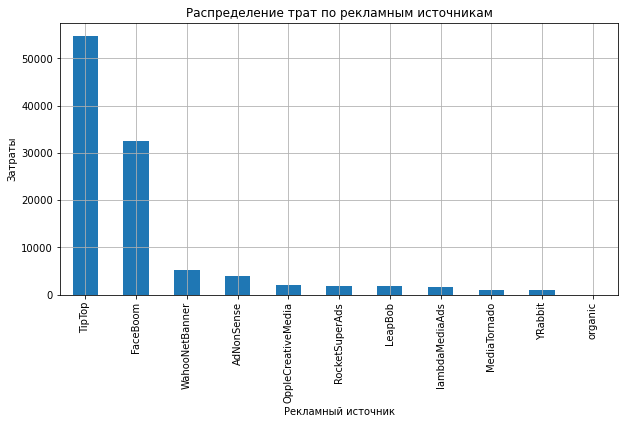

channel,TipTop,FaceBoom,WahooNetBanner,AdNonSense,OppleCreativeMedia,RocketSuperAds,LeapBob,lambdaMediaAds,MediaTornado,YRabbit,organic
total_cost,54751.3,32445.6,5151.0,3911.25,2151.25,1833.0,1797.6,1557.6,954.48,944.22,0.0


In [26]:
# создадим сводную таблицу с группировкой по каналу привлечения, для каждого канала будет посчитана сумма расходов на рекламу
# данные представим в виде столбчатой диагаммы
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')\
.rename(columns={'acquisition_cost': 'total_cost'}).sort_values('total_cost', ascending=False)\
.plot(kind='bar', grid=True, figsize=(10,5), legend=False)

plt.title('Распределение трат по рекламным источникам')
plt.xlabel('Рекламный источник')
plt.ylabel('Затраты')
plt.show()

# также отобразим числовые значения общей суммы затрат для каждого канала привлечения
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')\
.rename(columns={'acquisition_cost': 'total_cost'}).sort_values('total_cost', ascending=False).T

Наибольшие траты приходятся на рекламные источники TipTop (54751.30) и FaceBoom (3244.60). На остальные рекламные источники траты составляют от 1000 до 5000.

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Для этого добавим в датафрейм столбец с указанием номера недели. И создадим сводную таблицу, где сгруппируем данные по месяцам и номерам недель для каждого рекламного источника.

In [27]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week
cost_in_time = profiles.pivot_table(index=('month', 'week'), columns='channel', values='acquisition_cost', aggfunc='sum')\
                       .reset_index()

In [28]:
cost_in_time.head()

channel,month,week,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds,organic
0,2019-05-01,18,211.05,535.7,16.80,38.64,24.00,99.45,347.0,49.2,52.2,81.6,0.0
1,2019-05-01,19,273.00,750.2,31.71,61.68,34.50,139.23,470.0,92.4,75.9,103.2,0.0
2,2019-05-01,20,265.65,755.7,26.67,59.04,27.50,138.06,454.0,90.0,69.3,90.4,0.0
3,2019-05-01,21,266.70,722.7,26.67,50.16,34.25,131.04,801.8,79.2,65.4,119.2,0.0
4,2019-05-01,22,153.30,760.1,38.43,29.04,49.50,70.20,908.2,108.0,36.9,64.0,0.0


Построим соответствующие графики.

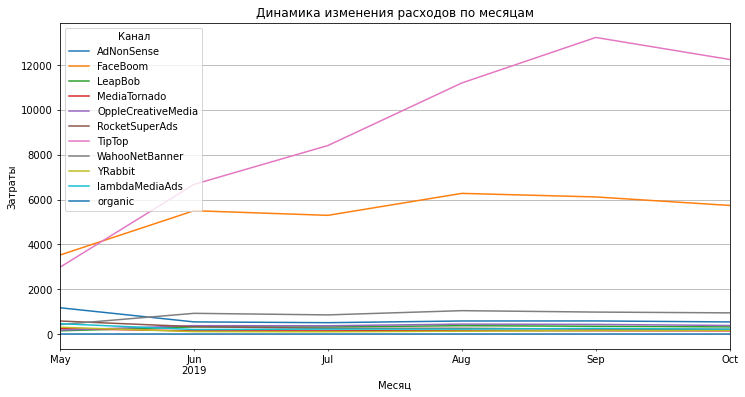

In [29]:
cost_in_time.groupby('month').agg('sum').drop(columns='week').plot(grid=True, figsize=(12, 6))

plt.title('Динамика изменения расходов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.legend(title='Канал')
plt.show()

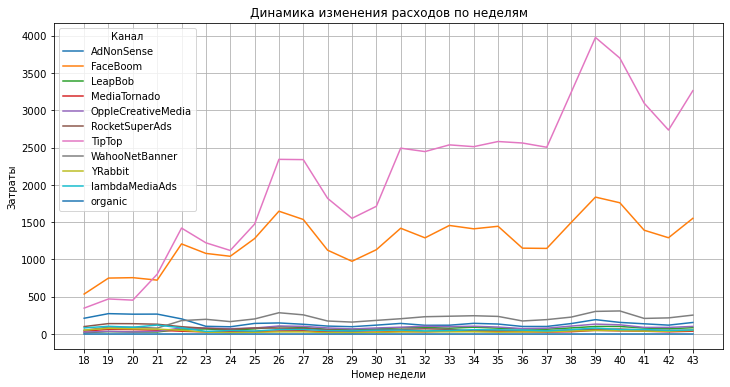

In [30]:
cost_in_time.groupby('week').agg('sum').plot(grid=True, figsize=(12, 6))

plt.title('Динамика изменения расходов по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Затраты')
plt.legend(title='Канал')
plt.xticks(list(cost_in_time.groupby('week').agg('sum').index.values))
plt.show()

На представленных выше графиках можно заметить постоянное увеличение месяц к месяцу расходов на рекламу в источнике TipTop с небольшим снижением в октябре. Траты на рекламу в иточнике FaceBoom росли с мая по июнь и далее до октября колеблются около отметки в 1500 в неделю или 6000 в месяц. Траты на рекламу в источнике TipTop снижались с 39 по 42 неделю года, после чего снова начали увеличиваться.

Также стоит отметить, что в целом наблюдается явная тенденция к росту расходов на рекламу.

Построим график истории изменений стоимости привлечения пользователя (CAC) по каналам привлечения.

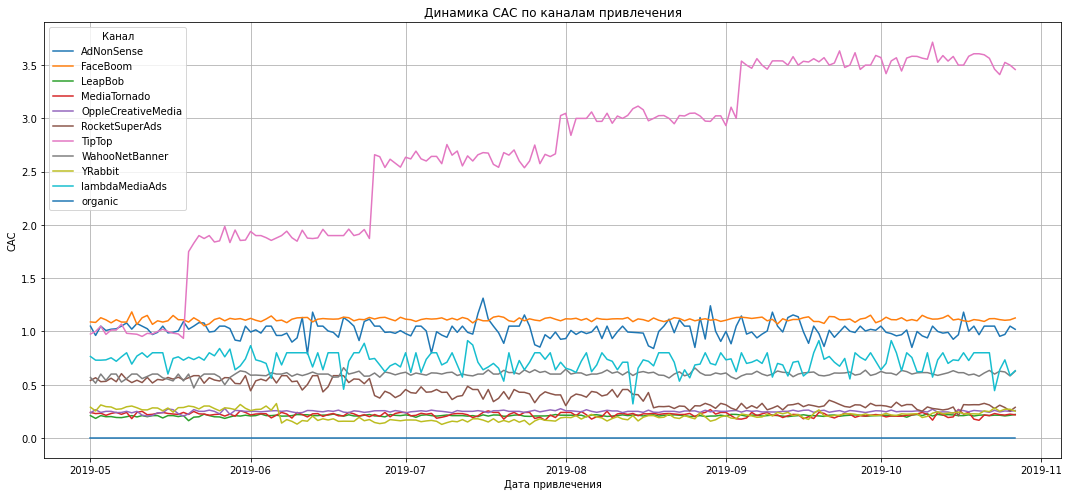

In [31]:
# создадим сводную таблицу с группировкой по дням, где для каждого канала будет показана средняя стоимость привлечения клиента
# для наглядности данные отобразим на графике
profiles.pivot_table(index='dt', values='acquisition_cost', columns='channel', aggfunc='mean')\
.plot(grid=True, figsize=(15, 7))

plt.xlabel('Дата привлечения')
plt.ylabel('CAC')
plt.title('Динамика САС по каналам привлечения')
plt.legend(title='Канал')

plt.tight_layout()
plt.show()

Выведем сводную таблицу со средней стоимостью привлечения пользователя за весь период (с 1 мая 2019 г. по 27 октября 2019 г.).

In [32]:
# создадим сводную таблицу с группировкой по каналам, для каждого канала будет показана средняя стоимость привлечения клиента
# за весь рассматриваемый период
mean_cost_per_user = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')\
.rename(columns={'acquisition_cost': 'mean_cost_per_user'}).sort_values('mean_cost_per_user', ascending=False)
mean_cost_per_user['mean_cost_per_user'] = round(mean_cost_per_user['mean_cost_per_user'], 2)
mean_cost_per_user

,mean_cost_per_user
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Средняя стоимость привлечения пользователя по каждому из каналов представлена в табилце вышле. По всем каналам стоимость привлечения пользователя стабильна, за исключением канала TipTop, где стоимость привлечения пользователя приблизительно раз в месяц повышается на 0,4-0,9.

### Оценка окупаемости рекламы

Построим графики LTV, ROI и CAC и проанализируем окупаемость рекламы. На момент обследования на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы.
- Проверим конверсию пользователей, динамику её изменения, а также удержание пользователей.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам, странам и рекламным каналам.

Зададим горизонт и момент анализа данных. 

In [33]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Т.к. мы оцениваем эффективность рекламы, при выполнении анализа в данном разделе органический трафик учитывать не будем.

In [34]:
profiles = profiles.query('channel != "organic"')

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

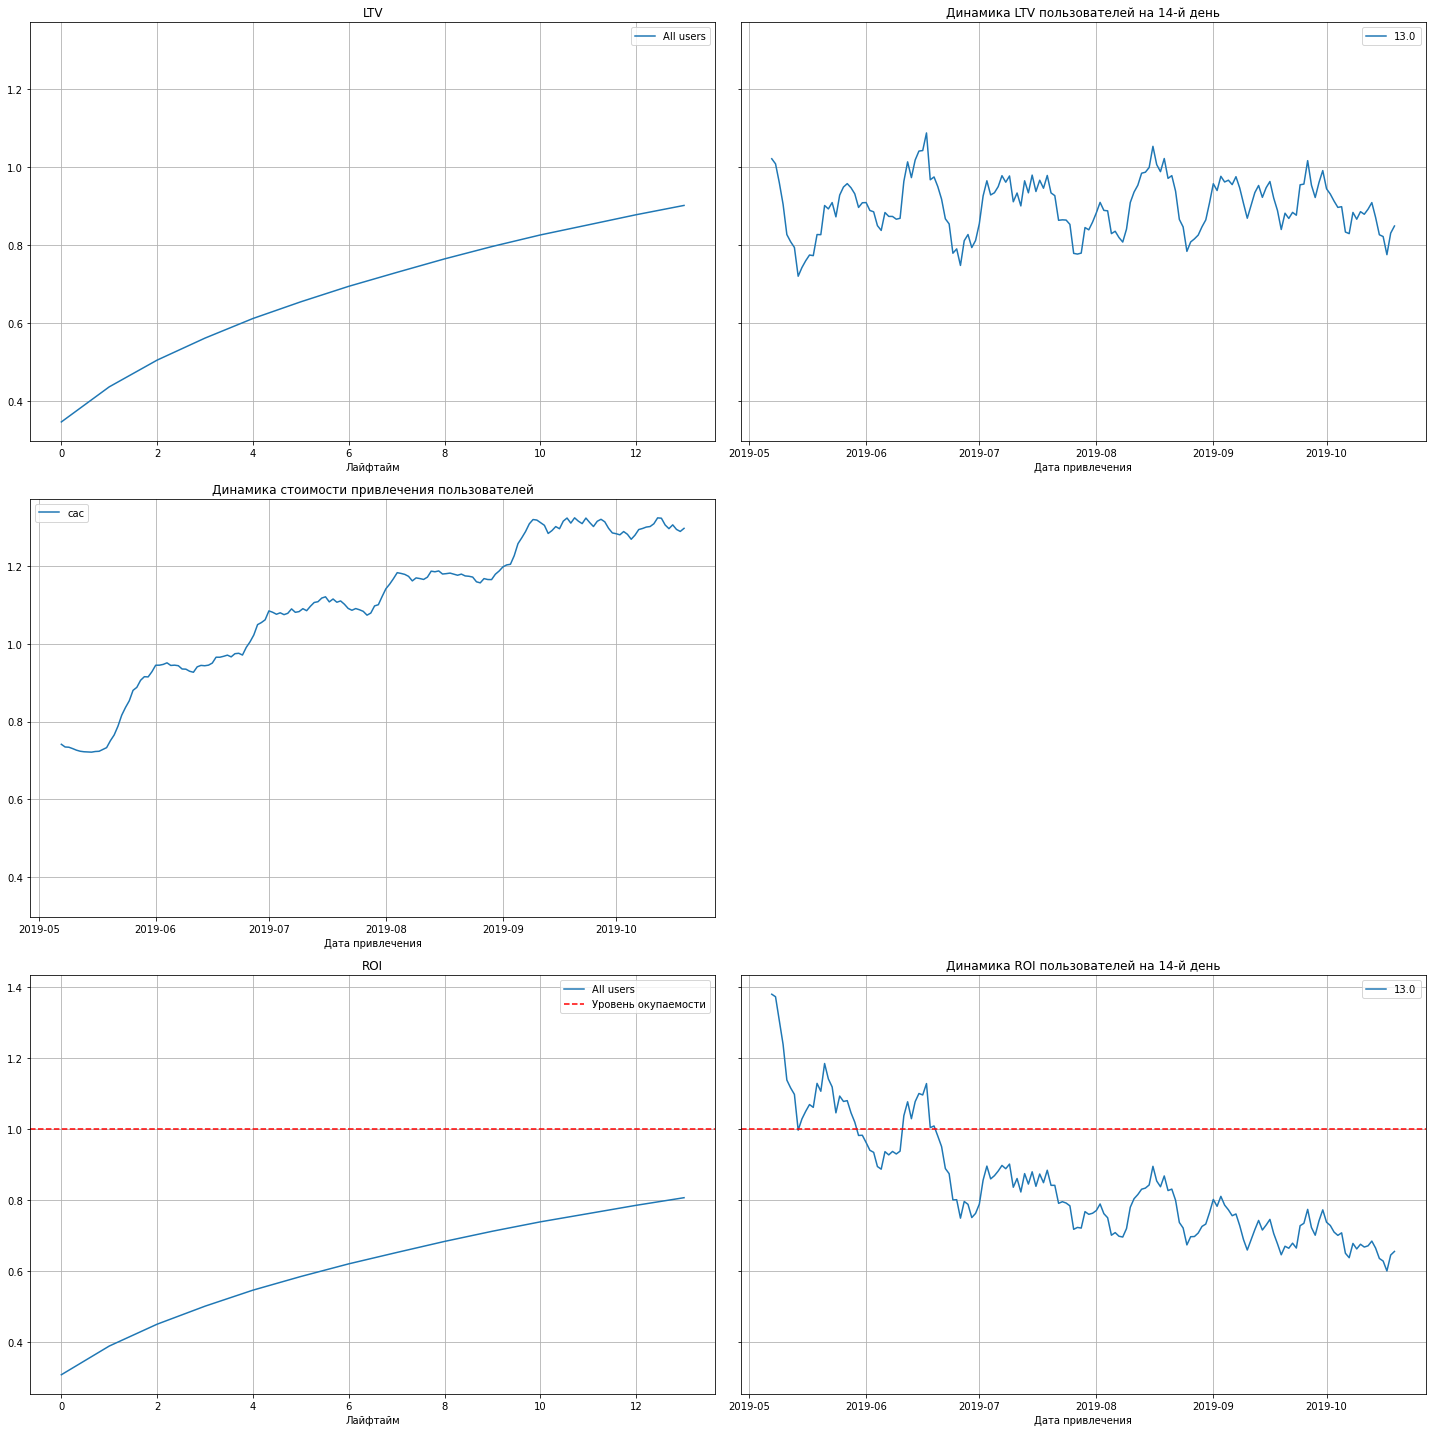

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history =\
get_ltv(profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать следующие выводы:
- Реклама не окупается. ROI в конце исследуемого периода (2 недели) составляет приблизительно 80%.
- СAC стабильно растет. Как было установлено ранее, это вызвано тем, что CAC из канала TipTop увеличивается.
- Показатель LTV имеет некую сезонность но в целом стабилен.
- Динамика ROI пользователей на 14-й день стабильно падает и с середины июня находится ниже уровня окупаемости.

Проверим конверсию и удержание пользователей и динамику их изменений. Построим и изучите графики конверсии и удержания.

Рассчитаем и визуализируем конверсию пользователей.

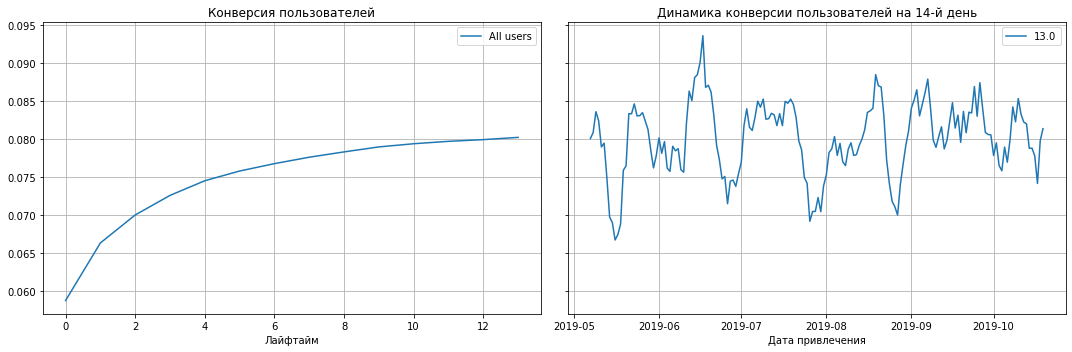

In [36]:
conversion_raw, conversion, conversion_history =\
get_conversion(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_history, horizon_days, window=7)

Конверсия пользователей постепенно растет на протяжении всех 14 дней. Динамика конверсии пользоваталей на 14-й день в среднем находится на уровне 8%.

Рассчитаем и визуализируем удержание пользователей.

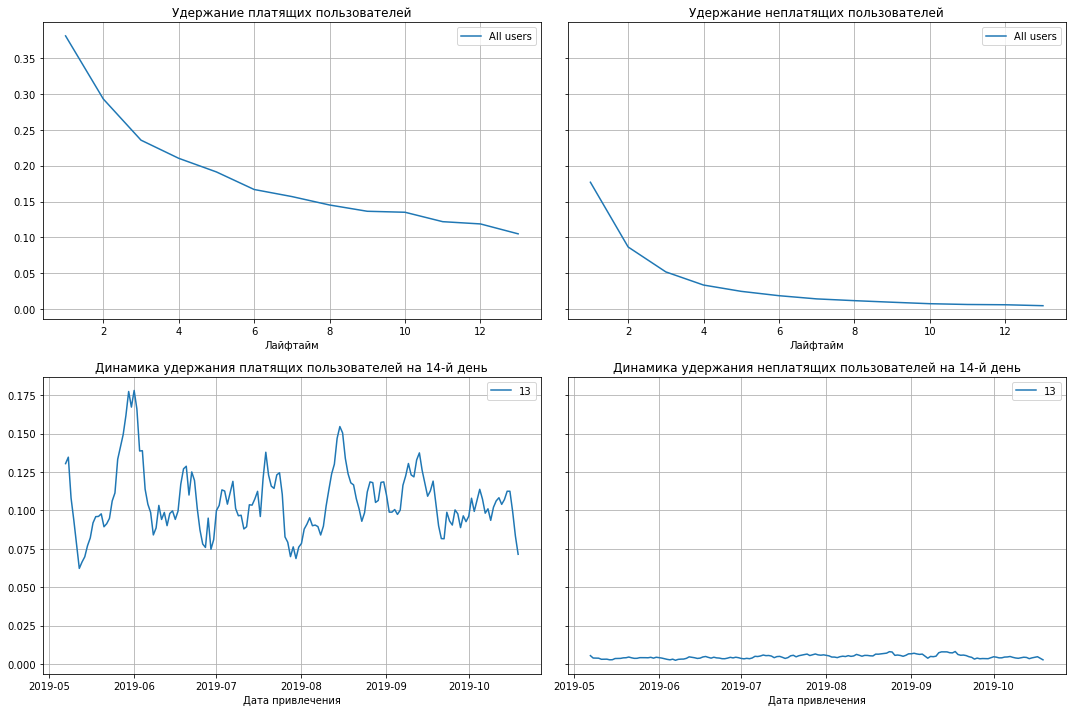

In [37]:
retention_raw, retention, retention_history =\
get_retention(profiles, visits, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days, window=7)

Удержание платящих пользователей а также динамика удержания платящих пользователей на 14 день значитально выше, чем неплатящих. 

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

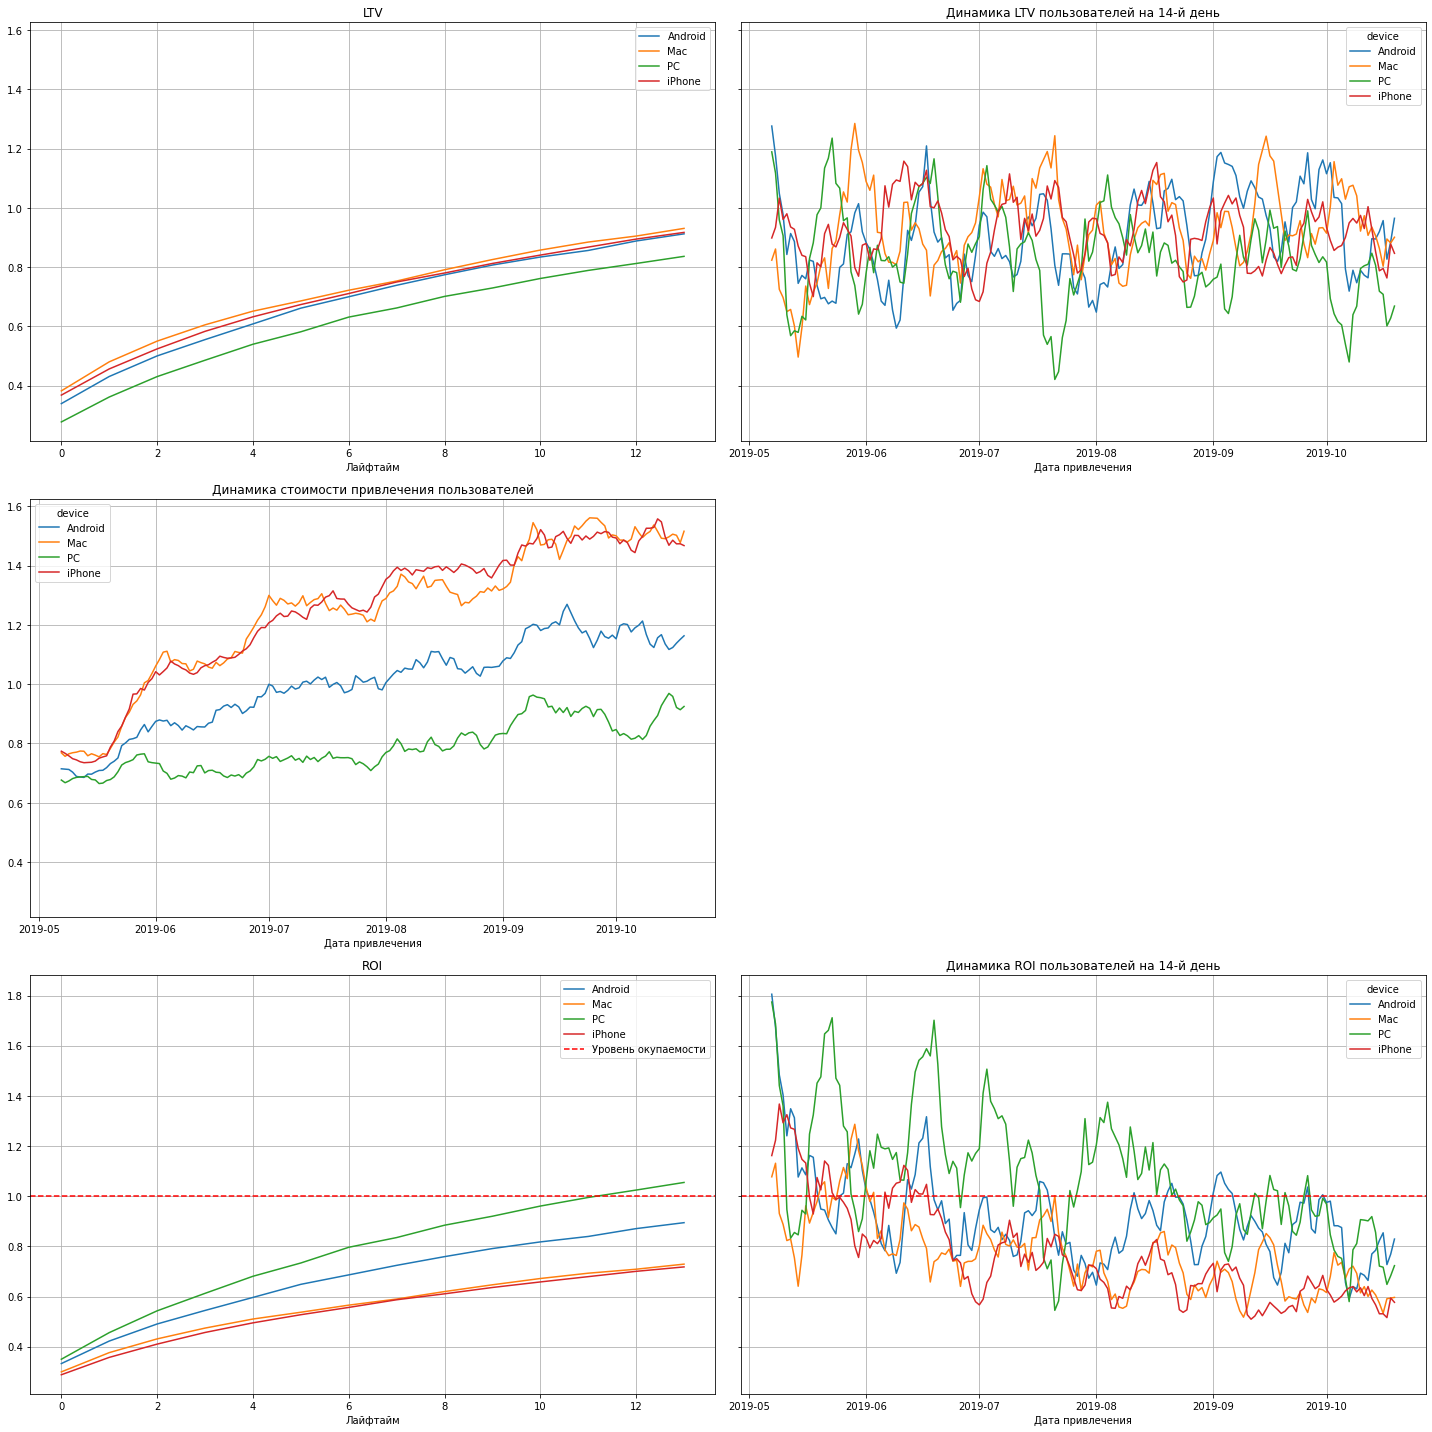

In [38]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history =\
get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:
- Пользователи PC платят меньше, чем пользователи других устройств, однако только пользователи PC окупаются за двухнедельный срок.
- LTV подвержен сезонности, но в целом стабилен.
- Наиболее подвержены росту стоимости привлечения пользователи Mac и iPhone. Меньше всего рост стоимости привлечения за исследуемый период показали пользователи PC.
- Динамика ROI пользователей на 14-й день стабильно падает

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

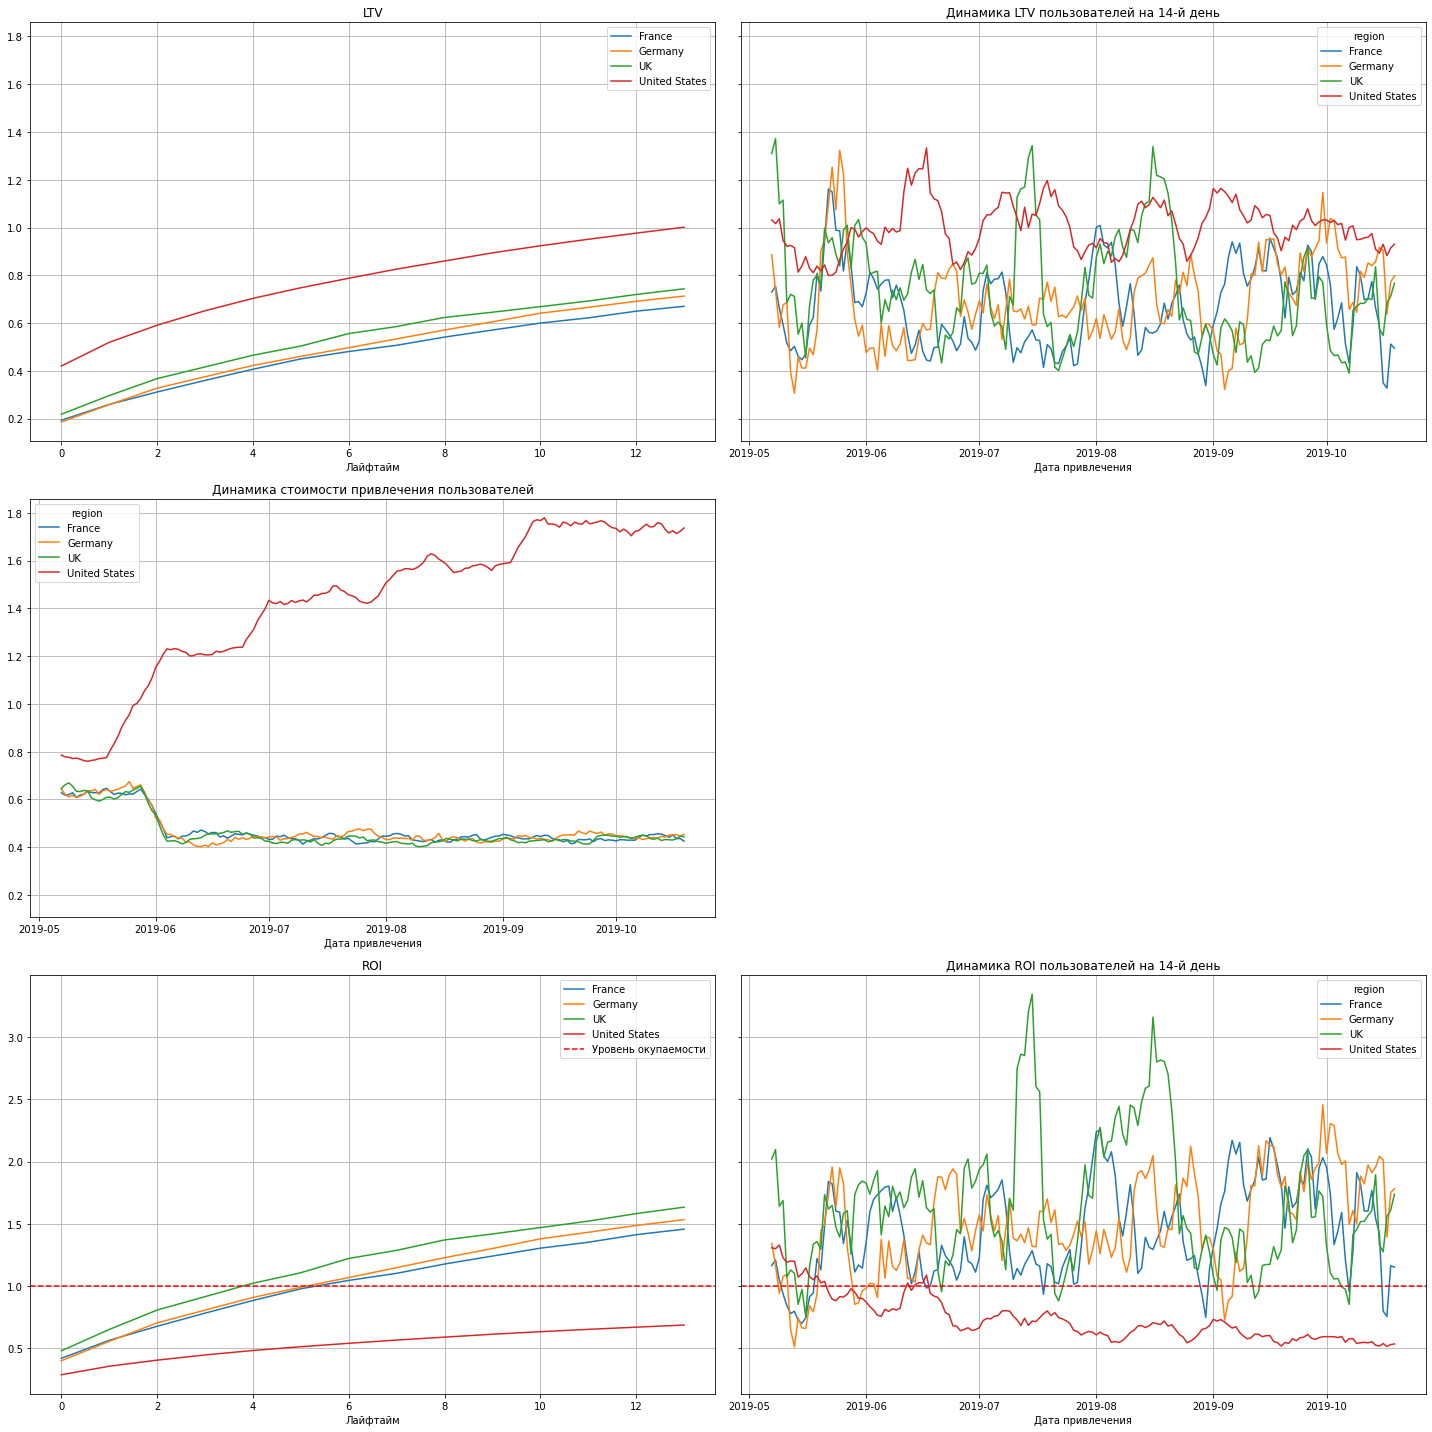

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history =\
get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Что можно отметить по графикам с разбивкой по странам:
- Реклама окупается везде, за исключением США.
- Пользователи из США имеют самый высокий LTV.
- Стоимость привлечения пользователей из США растет месяц к месяцу и на конец рассматриваемого периода значительно превышает стоимость привлечения пользователей других стран.
- Динамика LTV пользователей имеет сезонность, но в целом стабильна.
- Динамика ROI пользователей из США на 14-й день имеет тенденцию к снижению и с середины июня находится ниже уровня окупаемости.

Проанализируем окупаемость рекламы с разбивкой по рекламным компаниям. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

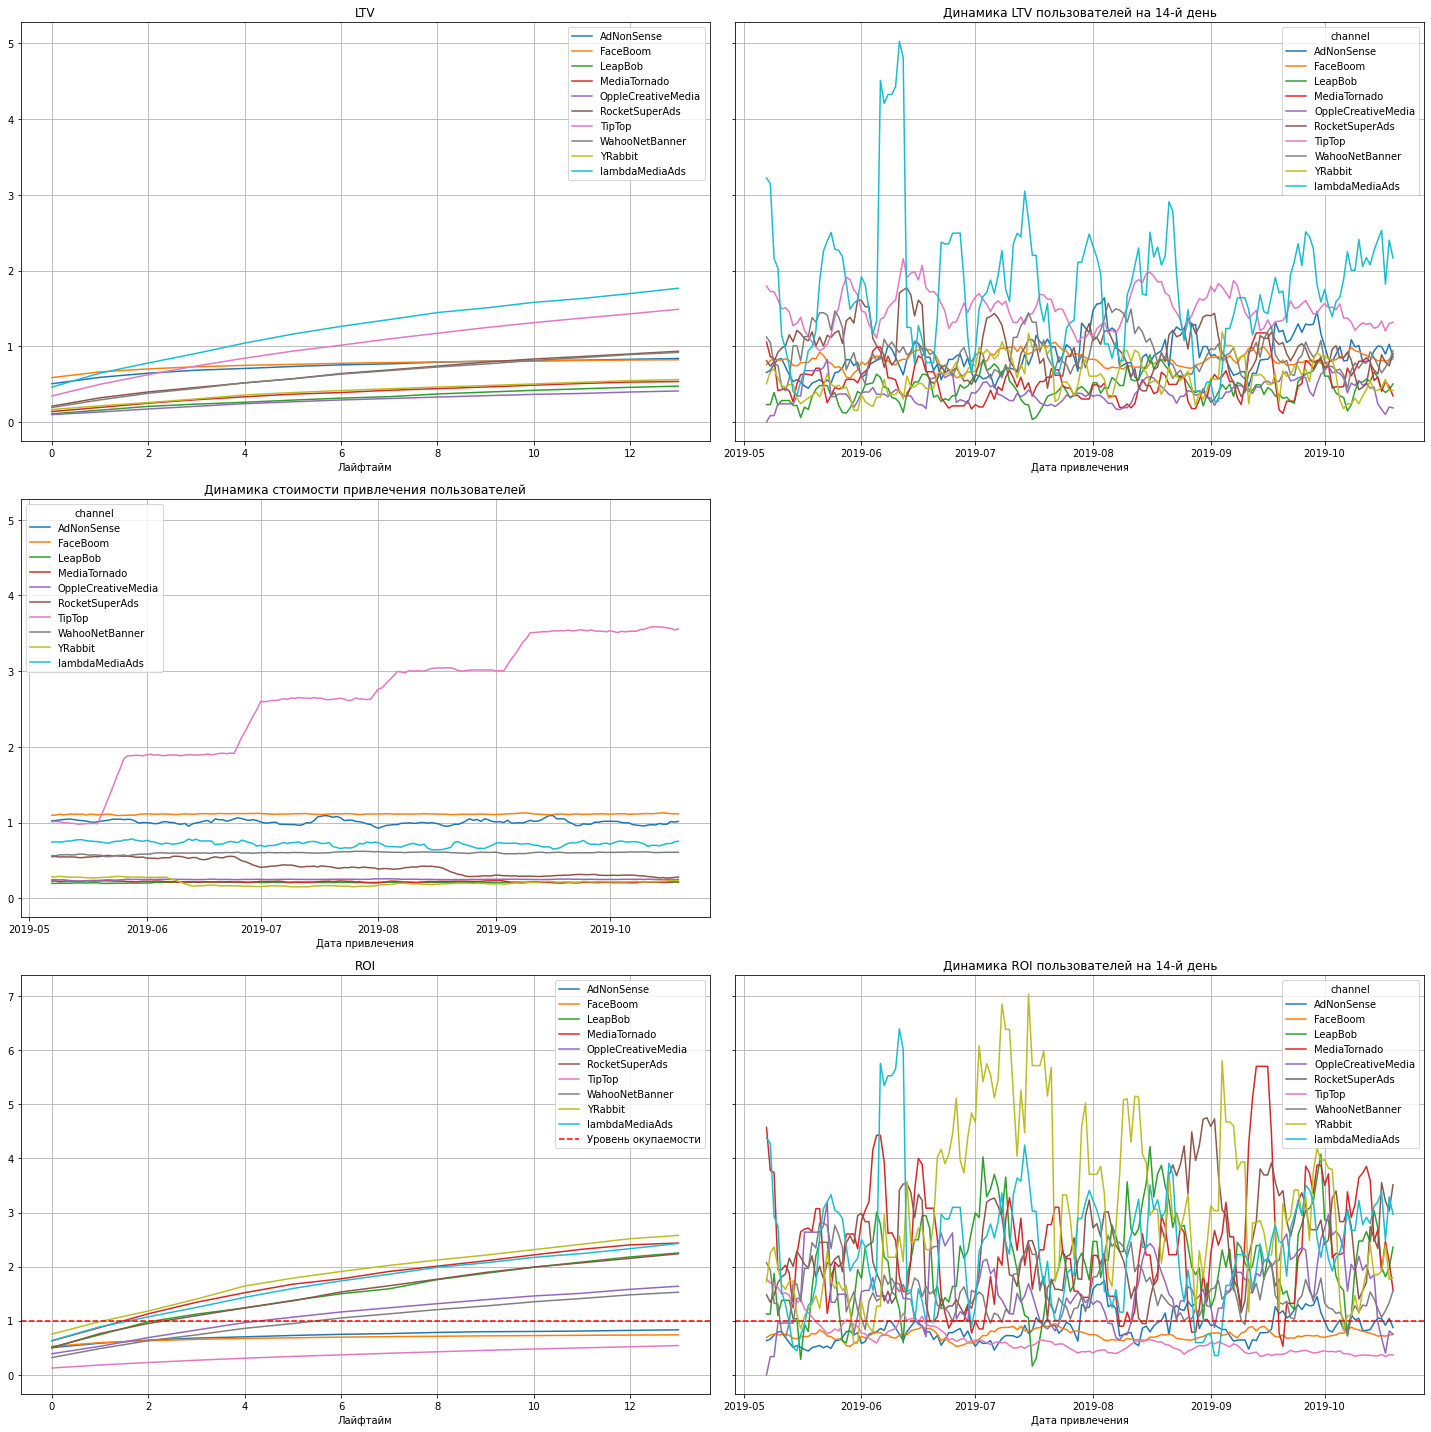

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history =\
get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам с разбивкой по каналам привлечения можно отметить следующее:
- Наиболее высокие показатели LTV имеют LambdaMediaAds и TipTop.
- Как уже отмечалось ранее, стоимость привлечения пользователей из TipTop имеет тенденцию к росту приблизительно каждый месяц.
- Окупаемость пользователей из канала Tip Top составляет примерно 50%, также ниже уровня окупаемости на 14-й день находятся пользователи из каналов AdNonSense и Faceboom.
- Самые дорогие каналы привелчения не окупаются.

Проверим, как изменялись расходы за исследуемый период для привлечения пользователей из каждого региона с разбивкой по каналам.

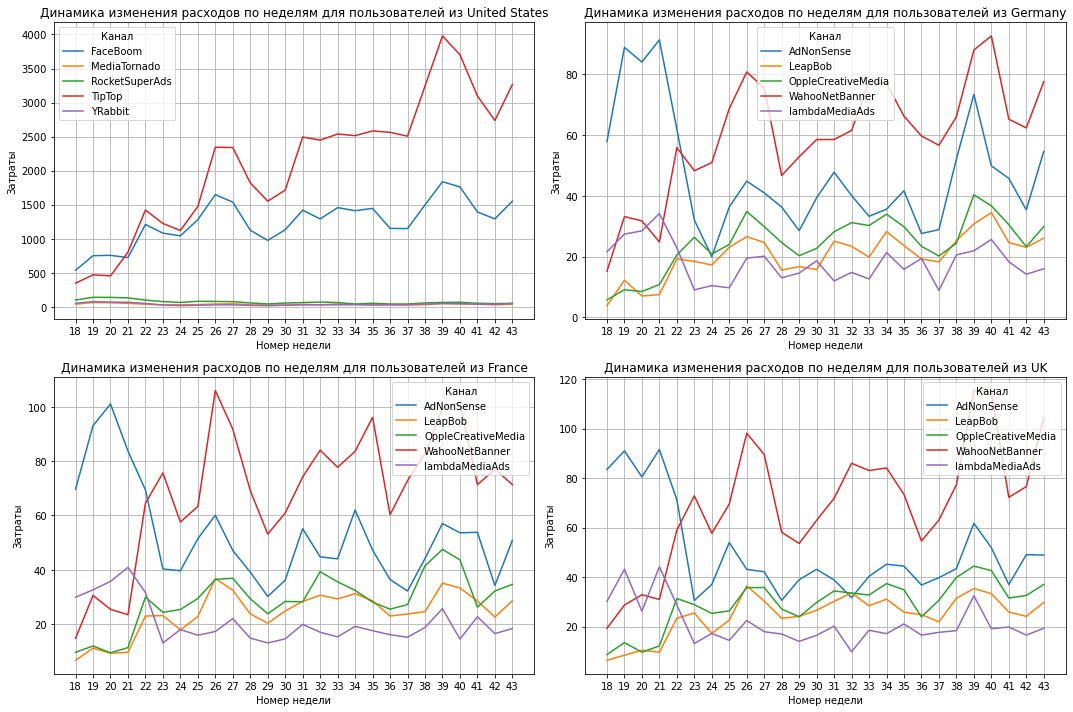

In [41]:
# создазим цикл, в котором переберем все регионы
plt.figure(figsize=(15, 10))
for i, val in enumerate(list(profiles['region'].unique())):
    
    # создадим сводную таблицу, где будет показана общая сумма затрат для каждого канала с разбивкой по неделям
    cost_in_time_reg = profiles.query('region == @val')\
                           .pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum')

    # построим график с динамикой изменения расходов по неделям
    cost_in_time_reg.plot(grid=True, ax=plt.subplot(2, 2, i+1))

    plt.title(f'Динамика изменения расходов по неделям для пользователей из {val}')
    plt.xlabel('Номер недели')
    plt.ylabel('Затраты')
    plt.legend(title='Канал')
    plt.xticks(list(cost_in_time_reg.index.values))
    
plt.tight_layout()
plt.show()

Траты на привлечение клиентов из США из неокупающихся рекламных компаний TipTip и FaceBoom стабильно росли. Стоит отметить, что по каналам TipTop и FaceBoom приходит трафик только из США.

Также проверим, как изменялись расходы за исследуемый период для привлечения пользователей различных устройств с разбивкой по каналам.

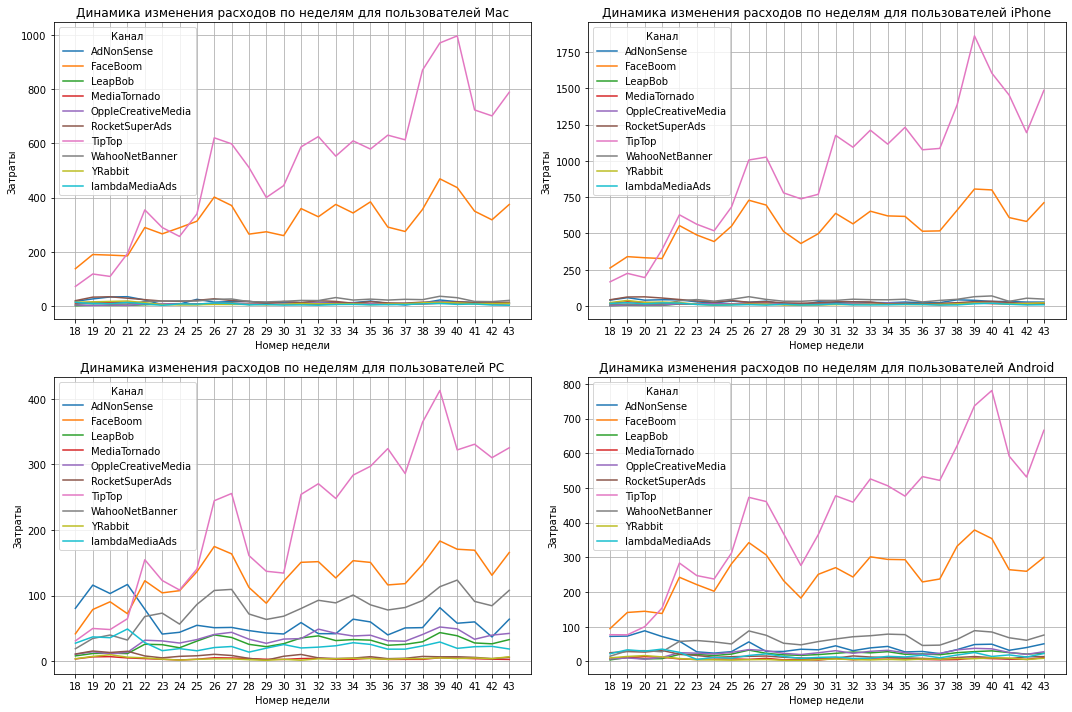

In [42]:
# создазим цикл, в котором переберем все устройства
plt.figure(figsize=(15, 10))
for i, val in enumerate(list(profiles['device'].unique())):
    
    # создадим сводную таблицу, где будет показана общая сумма затрат для каждого канала с разбивкой по неделям
    cost_in_time_reg = profiles.query('device == @val')\
                           .pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum')

    # построим график с динамикой изменения расходов по неделям
    cost_in_time_reg.plot(grid=True, ax=plt.subplot(2, 2, i+1))

    plt.title(f'Динамика изменения расходов по неделям для пользователей {val}')
    plt.xlabel('Номер недели')
    plt.ylabel('Затраты')
    plt.legend(title='Канал')
    plt.xticks(list(cost_in_time_reg.index.values))
    
plt.tight_layout()
plt.show()

Видим, что на привлечение пользователей iPhone, Mac, Android значительная часть трат приходится на неокупающиеся каналы TipTop и FaceBoom.

Построим графики конверсии и удержания пользователей с разбивкой по каналам.

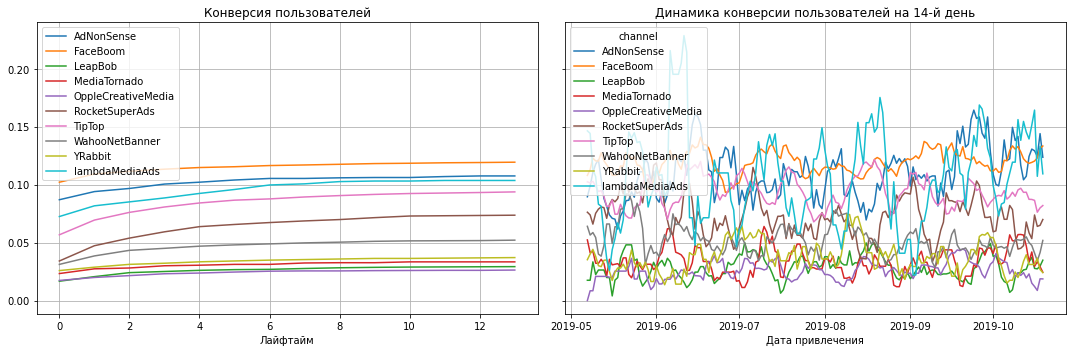

In [43]:
conversion_raw_ch, conversion_ch, conversion_history_ch =\
get_conversion(profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion_ch, conversion_history_ch, horizon_days, window=7)

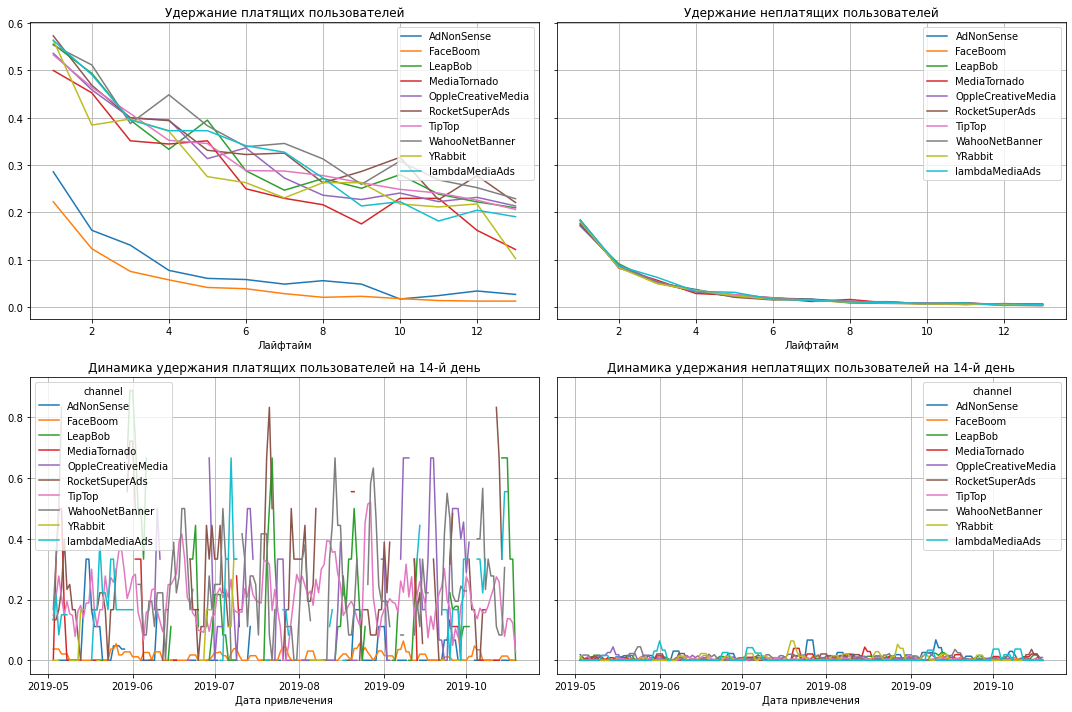

In [44]:
retention_raw_ch, retention_ch, retention_history_ch =\
get_retention(profiles, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention_ch, retention_history_ch, horizon_days, window=3)

Пользователи, привлеченные по каналам FaceBoom, AdNonSense имеют самые высокие показатели конверсии, но низкий показатель удержания платящих пользователей. Очень хорошо конвертируются пользователи lambdaMediaAds.

**Вывод:** в целом реклама, направленная на привлечение пользователей за рассматриваемый период в 14 дней не окупается.

TipTop является очень дорогим каналом, который забирает большая часть затрат на рекламу, являющуюся неэффективной. привлеченные по каналам FaceBoom, AdNonSense имеют самые высокие показатели конверсии, но низкий показатель удержания платящих пользователей. Очень хорошо конвертируются пользователи lambdaMediaAds.

При изолированном рассмотрении (поочередно разбивая пользователей по различным критериям на когорты и изучая бизнес показатели) можно сделать вывод, что негативное влияние на окупаемость рекламы могут оказывать следующие факторы:
- Пользователи устройств Mac и iPhone не окупаются и имеют самую низкую окупаемость (порядка 72%), пользователи Android также не окупаются (окупаемость 90%).
- Пользователи из США не окупаются (окупаемость порядка 70%).
- Окупаемость пользователей из канала Tip Top составляет примерно 50%, также ниже уровня окупаемости на 14-й день находятся пользователи из каналов AdNonSense (окупаемость около 85%) и Faceboom (окупаемость 75%).

Однако при анализе общей картины выявляется основная причина убытков компании. Проблемы окупаемости могут быть вызваны неправильным распределением трат по рекламным источникам. Наибольшие суммы средств расходуются на рекламу в источниках TipTop и FaceBoom, которые имеют самую низкую окупаемость. Большие затраты на привлечение пользователей из канала TipTop вызваны стабильным увеличением стоимости привлечения пользователя по данному каналу.

### Общий вывод

В результате исследования выполнен анализ бизнес показателей развлекательного приложения Procrastinate Pro+ и выявлены причины, по которым несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Исследование выполнено на предоставленных данных о пользователях, привлеченных с 1 мая по 27 октября 2019 года.

*Больше всего пользователей приходит из США.* Наибольшая доля платящих пользователей от общего количества по региону также приходится на США (6,9% платящих пользователей). В Германии, Великобритании и Франции доля платящих пользователей составляет около 4%.

Клиенты пользуются устройствами Mac, iPhone, PC, Android. *Доля платящих пользователей выше для пользователей Mac (6,36%) и iPhone (6,21%).* Среди платящих пользователей наибольшее количество использует iPhone.

*Наибольший процент платящих пользователей привлечен из каналов FaceBoom (12,2%), AdNonSense (11,34%), LambdaMediaAds (10,47%).* Менее всего платящих пользователей привлеченно из LeapBob (3,06%) и OppleCreativeMedia (2,71%). В органическом трафике платящих пользователей 2,06%.

*Общая сумма расходов на маркетинг за исследуемый период $105497.30.*

Наибольшие траты приходятся на рекламные источники TipTop (54751.30) и FaceBoom (3244.60).* На остальные рекламные источники траты составляют от 1000 до 5000.

**Из общей динамики изменения расходов по времени выявлено следующее:** постоянное увеличение месяц к месяцу расходов на рекламу в источнике TipTop с небольшим снижением в октябре. Траты на рекламу в иточнике FaceBoom росли с мая по июнь и далее до октябя колеблются около отметки в 1500 в неделю или 6000 в месяц. Траты на рекламу в источнике TipTop снижались с 39 по 42 неделю 2019 года, после чего снова начали увеличиваться. В целом наблюдается явная тенденция к росту расходов на рекламу.

*Средняя стоимость за исследуемый период привлечения одного пользователя из различных каналов в долларах*:
- TipTop - 2.80
- Faceboom - 1.11
- AdNonSense - 1.01
- lambdaMediaAds - 0.72
- WahooNetBanner - 0.60
- RocketSuperAds - 0.41
- OppleCreativeMedia - 0.25
- YRabbit - 0.22
- MediaTornado - 0.22
- LeapBob - 0.21

По всем каналам стоимость привлечения пользователя стабильна, за исключением канала TipTop, где стоимость привлечения пользователя приблизительно раз в месяц повышается на 0,4-0,9.

*Для анализа ROI, LTV, также динамики LTV, CAC и ROI принят момент анализа 1 ноября 2019 г. и горизонт анализа в 14 дней.*

**В результате оценки окупаемости рекламы без разделения пользователей на когорты установлено следующее:**
- Реклама не окупается. Окупаемость инвестиций в конце исследуемого периода (2 недели) составляет приблизительно 80%.
- Стоимость привлечения пользователей стабильно растет. Как было установлено ранее, это вызвано тем, что стоимость привлечения пользователей из канала TipTop увеличивается.
- Показатель пожизненной ценности клиента имеет некую сезонность но в целом стабилен.
- Динамика окупаемости инвестиций на 14-й день стабильно падает и с середины июня находится ниже уровня окупаемости.

Конверсия пользователей на 14-й день в среднем составляет 8%.

**В результате оценки окупаемости рекламы с разделением пользователей по устройствам, по странам и по источникам привлечения установлено следующее:**
- Пользователи PC платят меньше, чем пользователи других устройств, однако только пользователи PC окупаются за двухнедельный срок.
- Наиболее подвержены росту стоимости привлечения пользователи Mac и iPhone. Меньше всего рост стоимости привлечения за исследуемый период показали пользователи PC.
- Реклама окупается везде, за исключением США.
- Пользователи из США платят больше, чем пользователи из других стран.
- Стоимость привлечения пользователей из США растет месяц к месяцу и на конец рассматриваемого периода значительно превышает стоимость привлечения пользователей других стран.
- Динамика окупаемости инвестиций за пользователей из США на 14-й день за исследуемый период имеет тенденцию к снижению и с середины июня находится ниже уровня окупаемости.
- Пользователи, привлеченные из каналов LambdaMediaAds и TipTop платят больше, чем пользователи из других каналов.
- Стоимость привлечения пользователей из TipTop имеет тенденцию к росту приблизительно каждый месяц.
- Окупаемость пользователей из канала Tip Top составляет примерно 50%, также ниже уровня окупаемости на 14-й день находятся пользователи из каналов AdNonSense и FaceBoom.

**Причины неэффективности привлечения пользователей.**

Проблемы окупаемости могут быть вызваны неправильным распределением расходов по рекламным источникам. Наибольшие суммы средств расходуются на рекламу в источниках TipTop и FaceBoom, которые имеют самую низкую окупаемость. Большие затраты на привлечение пользователей из канала TipTop вызваны стабильным увеличением стоимости привлечения пользователя по данному каналу. Стоимость привлечения пользователей из источника FaceBoom не растет, однако пользователи из данного источника также не окупаются. По каналам TipTop и FaceBoom приходит трафик из США. Т.к. больший вес от общего числа пользователей приложения составляют пользователи из США, а основная часть средств на рекламу расходуется на привлечение пользователей из источников с самой низкой окупаемостью (значительно ниже уровня окупаемости), общая окупаемость пользователей за период в 14 дней не достигает уровня окупаемости.

*Промежуточные рекомендации для отдела маркетинга:*
- *целесообразно сменить преоритет расходов с неокупающихся TipTop и FaceBoom на другие источники трафика для пользователей из США (например на YRabbit и MediaTornado, пользователи из которых окупаются лучше всего)*
- *снизить траты на привлечение клиентов из источника AdNonSense (для регионов Великобритании, Германии и Франции), т.к. пользователи из данного канала не окупаются*
- *для увеличения эффективности маркетинга следует обратить внимание на компанию lambdaMediaAds (наиболее предпочтительно) и RocketSuperAds с хорошими показателями конверсии пользователей и окупаемости инвестиций.*
- *после корректировки маркетинговой компании и сбора достаточного количества данных можно будет выполнить анализ и выделить отдельные когорты пользователей по региону и устройству, на которые следует сделать упор при дальнейшем планировании рекламного бюджета*